In [42]:
'''
Tasks:

-- Date preprocessing -- 
    converting dates between languages, and then structure
    --> alternatively, we can duplicate the set, change weird dates to none
    
--feature creation--
    date by year
    looking at if they are posting weekday/weekend might suggest that they are working age
    language (foreign in general or specifics)
    number of posts per user.id
    
-- text --
    remove the stopwords
        NLTK
    remove the punctuation
    stemming the words
    SVD (singular value decomposition) --> will show what is most important by 
        taking the matrix of term counts (needs to be created), but returns importance values ~ variability with each word
    TF-IDF: could filter down to top 500-1000 words (we can probably just implement using a package) 
        if not...
        calculate the frequency of word in every document
        inverse log 
        
-- train model: multiple linear regression --
    glm net --> just make sure not to do log, but can still use this for normal parametric
        (generalization of ridge and lasso regression)
    
    CV procedure to judge accuracy of predictor based on words we keep or parameters of the linear model

    
general notes: what is a document?

    post?
        -this would let us use the distribution of predictions for a user to do a second layer to the model
        -potentially average/take median of different predictions for individual documents
        
        -might want to consider the number of unique pairings between user.id and post.id
        
    single user?
    
    bigrams or trigrams instead of words (two or three words in order can be treated as words)
        n words in sentence --> n-1 bigrams --> blows up dimensionality, but could give more information because context
        comes into play (may or may not be feasible depending on our corpus)
        
        
Note from Sean: We may want to use the "gensim" package, which is Google's pre-trained word2vec model, which I think could be really useful.

'''
;

''

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn as slr
import nltk

In [2]:
# Set wd
#os.chdir("C://Users/alxgr//Documents//UVA//DSI//Fall 2018//SYS//Kaggle Competition 3//sys6018-competition-blogger-characteristics")
os.chdir("/Users/SM/DSI/classes/fall2018/SYS6018/kaggle/sys6018-competition-blogger-characteristics/")

In [3]:
# read in data
train = pd.read_csv(os.path.join("data", "input", "train.csv"))
test = pd.read_csv(os.path.join("data", "input", "test.csv"))

In [11]:
# start data exploration
train.head()

,post.id,user.id,gender,topic,sign,date,text,age
0,1,11869,male,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",15
1,2,11869,male,Student,Leo,"13,May,2004",These are the team members: Drewe...,15
2,3,11869,male,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,15
3,4,11869,male,Student,Leo,"12,May,2004",testing!!! testing!!!,15
4,5,16332,male,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,33


In [12]:
pd.set_option('display.max_rows', 5000)
train.groupby(['user.id', 'post.id']).size()

user.id  post.id
1        592732     1
         592733     1
         592734     1
         592735     1
         592736     1
         592737     1
         592738     1
         592739     1
         592740     1
         592741     1
         592742     1
         592743     1
         592744     1
         592745     1
         592746     1
         592747     1
         592748     1
         592749     1
         592750     1
         592751     1
         592752     1
         592753     1
         592754     1
         592755     1
         592756     1
         592757     1
         592758     1
         592759     1
         592760     1
         592761     1
         592762     1
3        282649     1
         282650     1
         282651     1
         282652     1
         282653     1
         282654     1
         282655     1
         282656     1
4        563519     1
5        263002     1
         263003     1
         263004     1
         263005     1
         263006

In [13]:
train.shape

(442961, 8)

In [14]:
train.describe()

,post.id,user.id,age
count,442961.000000,442961.000000,442961.000000
mean,340076.005231,9655.198203,23.540594
std,196532.771521,5512.481177,7.603127
min,1.000000,1.000000,13.000000
25%,168419.000000,4760.000000,17.000000
50%,341752.000000,9630.000000,24.000000
75%,510601.000000,14278.000000,26.000000
max,681161.000000,19319.000000,48.000000


In [15]:
train.isnull().sum()
test.isnull().sum()

post.id    0
user.id    0
gender     0
topic      0
sign       0
date       0
text       0
dtype: int64

In [16]:
train.topic.value_counts()

indUnk                     159419
Student                    102746
Technology                  28346
Arts                        24313
Education                   18563
Communications-Media        13195
Non-Profit                   9036
Internet                     8865
Engineering                  7139
Publishing                   5614
Law                          5502
Science                      4876
Consulting                   4540
Government                   3946
Religion                     3466
BusinessServices             3454
Marketing                    3130
Fashion                      2755
Chemicals                    2680
Museums-Libraries            2636
Sports-Recreation            2523
Advertising                  2502
Telecommunications           2464
HumanResources               2274
Banking                      2199
Accounting                   2185
Military                     1795
RealEstate                   1672
Transportation               1517
Manufacturing 

In [17]:
train.sign.value_counts()

Taurus         42051
Libra          41088
Virgo          40923
Scorpio        38548
Cancer         38104
Leo            36809
Aries          36714
Aquarius       35634
Sagittarius    34692
Pisces         32846
Gemini         32831
Capricorn      32721
Name: sign, dtype: int64

In [4]:
# join data sets
test['age'] = None
train['set'] = "train"
test['set'] = "test"

In [19]:
test.head()

,post.id,user.id,gender,topic,sign,date,text,age,set
0,96,4876,female,indUnk,Capricorn,"08,August,2004","urlLink im new to this, ...",None,test
1,97,4876,female,indUnk,Capricorn,"08,August,2004",Election time has rolled aro...,None,test
2,108,12227,female,Student,Aries,"31,July,2004","Met Lim this morning, then we...",None,test
3,109,12227,female,Student,Aries,"30,July,2004",Such a boring day. I have no ...,None,test
4,110,12227,female,Student,Aries,"29,July,2004","Nuts. As usual, Theo and I pl...",None,test


In [5]:
alldata = pd.concat([train, test])

In [6]:
alldata.isnull().sum()

post.id         0
user.id         0
gender          0
topic           0
sign            0
date            0
text            0
age        238323
set             0
dtype: int64

In [7]:
# convert to datetime, leaving non-valid/non-English dates null
alldata['date_date'] = pd.to_datetime(alldata.date, errors='coerce')

In [8]:
# Remove rows where date cannot be parsed - these are non-English and so unless translated
# into English, cannot be used in a text model with this corpus
alldata = alldata[alldata['date_date'].notnull()]
alldata.date = alldata.date_date
alldata = alldata.drop(['date_date'], axis=1)

In [9]:
# adjusting age to age at date of posting by subtracting post date from max(post dates)
# This may be a bad idea if ages are already age at time of posting. I think that is actually the case upon inspection.
alldata['adj_age'] = alldata.age - (2006 - alldata['date'].dt.year)
alldata.adj_age = alldata.adj_age.astype(float)

235046

In [39]:
alldata.head()

,post.id,user.id,gender,topic,sign,date,text,age,set,adj_age
0,1,11869,male,Student,Leo,2004-05-14,"Info has been found (+/- 100 pages,...",15,train,13.0
1,2,11869,male,Student,Leo,2004-05-13,These are the team members: Drewe...,15,train,13.0
2,3,11869,male,Student,Leo,2004-05-12,In het kader van kernfusie op aarde...,15,train,13.0
3,4,11869,male,Student,Leo,2004-05-12,testing!!! testing!!!,15,train,13.0
4,5,16332,male,InvestmentBanking,Aquarius,2004-06-11,Thanks to Yahoo!'s Toolbar I can ...,33,train,31.0


In [10]:
alldata.describe()

,post.id,user.id,adj_age
count,673538.000000,673538.00000,438492.000000
mean,340564.101435,9588.18959,21.318742
std,196611.977137,5682.78550,7.604802
min,1.000000,1.00000,6.000000
25%,170738.250000,4379.00000,14.000000
50%,340700.500000,9726.00000,22.000000
75%,510687.750000,14498.00000,24.000000
max,681284.000000,19320.00000,46.000000


In [195]:
# Start doing text processing for exploration here

samp = alldata.sample(500)['text']

In [198]:
samp[380407]

"           A new day again. First day as a free man, i might say. I was just thinking that if i wanted, i could get a job now. A real job. Not that i would want one. My plan is to stall with any real working as long as i can. That means another 3 years in school and then some university onto the top of it all.   Woke up late today. Felt nice. If i succseed in getting myself slicks today, wich i probably wont, because my parents' wallets are not endless and my stomach can only take a knife once in a while, it will be all the better.   Also going to have tea and cake with grandparents. Getting the education and all. They have helped me a lot with it, too. My grandmother has taught me russian and my granfather, a mathemathics professor, has taught me math. I really love them for that. But not just for that, obviously. So yes, tea and cake.   [music: The Best Jazz Album In The World]  A two-disc collection of good jazz songs. Some too slow for me, though. I dont much like slow music. Curr

In [199]:
import nltk
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

In [250]:
# filter to training data and subsample for simplicity
smallDF = alldata[alldata.age.notnull()]
smallDF = smallDF.sample(500)


In [251]:
smallDF.describe()

,post.id,user.id,adj_age
count,500.000000,500.000000,500.000000
mean,338346.372000,9825.130000,21.052000
std,199900.202807,5612.652179,7.562518
min,5147.000000,6.000000,11.000000
25%,161725.250000,4759.000000,14.000000
50%,326645.000000,9774.500000,21.000000
75%,519906.750000,14993.250000,24.000000
max,680624.000000,19313.000000,46.000000


In [252]:
# lowercase, tokenize & stem words in text
smallDF['text'] = smallDF['text'].apply(str.lower)
smallDF['tokens']=smallDF['text'].apply(nltk.word_tokenize)
smallDF['tokens']=[[porter.stem(x) for x in tokens] for tokens in smallDF['tokens']]
smallDF['tokens']=[[w for w in tokens if not w in stop_words] for tokens in smallDF['tokens']]
smallDF['tokens']=[[w for w in tokens if w.isalpha()] for tokens in smallDF['tokens']]


In [253]:
#smallDF['newtext'] = smallDF['tokens'].apply(nltk.Text)
#smallDF['newtext'][158990].collocations()
smallDF['newtext'] = smallDF['tokens'].apply(lambda x: " ".join(x))

In [254]:
smallDF['newtext']

318872    even gotten pyjama sort state situat right yes...
406185    long get basic famili ha money becom thi mom h...
116412    browser msie open document automat without ask...
220758    manag work today came said mike got question c...
319049    wa listen rush limbaugh day excus sorri heard ...
105613    va absolut agre time use forc mean ralli every...
103333                  urllink logitech webcam follow face
213020                                 urllink famou leader
282678    king pick histori samuel finish david old king...
38505     mayb mention hiplog hope take everi friday mon...
264219    urllink justros favorit natur phenomenon sarca...
100503                                                     
25749     septemb commiss ha urllink report envis ten ai...
140351    urllink realli like thi pictur love pacifi tot...
297310    north carolina great state snow inch governor ...
30849     urllink thi think ideal must bone diet like nb...
238378    event appear inexplic law natu

In [255]:
#from collections import Counter
#smallDF['textdic'] = smallDF['tokens'].apply(Counter)
#smallDF['textdic'] 


In [256]:
#allwordset = set()
#[[allwordset.add(x) for x in d.keys()] for d in smallDF['textdic']]
#allwordset

In [257]:
# Do imports
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [258]:
# Create Term-Document Matrix
vectorizer = CountVectorizer()
tdm = vectorizer.fit_transform(smallDF['newtext'])

In [259]:
#print(vectorizer.get_feature_names())
print(tdm.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [260]:
# TFIDF transform
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(tdm)

In [261]:
print(tfidf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [262]:
vectorizer.get_feature_names()

['aaa',
 'aaaaahh',
 'aahhh',
 'aask',
 'aayush',
 'aayusin',
 'abandon',
 'abba',
 'abc',
 'abdel',
 'abdullahi',
 'abi',
 'abil',
 'abl',
 'abomin',
 'aborigin',
 'abort',
 'abound',
 'abov',
 'abroad',
 'absolut',
 'absolutli',
 'absorb',
 'abstain',
 'abstin',
 'abstract',
 'absurd',
 'abt',
 'abund',
 'abus',
 'abyss',
 'aca',
 'academ',
 'academi',
 'accent',
 'accept',
 'access',
 'accident',
 'acclim',
 'accompani',
 'accomplish',
 'accord',
 'account',
 'accredit',
 'accross',
 'accur',
 'accus',
 'ace',
 'ach',
 'acheiv',
 'achiev',
 'acjc',
 'acknowledg',
 'ackward',
 'acoust',
 'acquaint',
 'acquir',
 'acquisit',
 'acronym',
 'across',
 'act',
 'action',
 'activ',
 'actor',
 'actress',
 'actual',
 'acut',
 'ad',
 'ada',
 'adalah',
 'adam',
 'adapt',
 'add',
 'addict',
 'addit',
 'address',
 'adecuada',
 'adeui',
 'adieu',
 'adik',
 'aditlo',
 'adject',
 'adjust',
 'administ',
 'administr',
 'admir',
 'admit',
 'adn',
 'adolenc',
 'adopt',
 'ador',
 'adsl',
 'adult',
 'advan

In [263]:
from sklearn.linear_model import ElasticNetCV

In [264]:
shorterDF = smallDF[smallDF['age'].notnull()]

In [268]:
y = smallDF.age
X = tfidf

In [269]:
# Do elasticnet CV training
regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(X, y)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto', random_state=0,
       selection='cyclic', tol=0.0001, verbose=0)

In [304]:
regr.score(X, y)

0.7789954112847757

In [317]:
regr.mse_path_

array([[64.66106784, 50.04123403, 56.8572    , 48.63257291, 63.30262307],
       [64.64467311, 50.03059732, 56.8572    , 48.6220866 , 63.29694337],
       [64.62738122, 50.01940915, 56.8572    , 48.61107092, 63.29100278],
       [64.60916334, 50.00765624, 56.8572    , 48.59951552, 63.28480021],
       [64.58999255, 49.99532716, 56.8572    , 48.58741229, 63.2783363 ],
       [64.5698443 , 49.98241266, 56.8572    , 48.57475566, 63.27161362],
       [64.54869692, 49.96890609, 56.8572    , 48.56154305, 63.26463689],
       [64.52653219, 49.95480369, 56.84775881, 48.54777527, 63.25741325],
       [64.50333588, 49.94010508, 56.80823524, 48.53345695, 63.2499525 ],
       [64.47909842, 49.92481361, 56.76661809, 48.51859698, 63.24226735],
       [64.45381548, 49.90893679, 56.72284639, 48.50320898, 63.23437364],
       [64.42627807, 49.89248672, 56.68085633, 48.48731171, 63.22629058],
       [64.39740285, 49.87548043, 56.64513692, 48.46960486, 63.21755983],
       [64.36742444, 49.85820526, 56.6

In [316]:
np.reshape(regr.mse_path_, (len(regr.alphas_), regr.cv))

array([[64.66106784, 50.04123403, 56.8572    , 48.63257291, 63.30262307],
       [64.64467311, 50.03059732, 56.8572    , 48.6220866 , 63.29694337],
       [64.62738122, 50.01940915, 56.8572    , 48.61107092, 63.29100278],
       [64.60916334, 50.00765624, 56.8572    , 48.59951552, 63.28480021],
       [64.58999255, 49.99532716, 56.8572    , 48.58741229, 63.2783363 ],
       [64.5698443 , 49.98241266, 56.8572    , 48.57475566, 63.27161362],
       [64.54869692, 49.96890609, 56.8572    , 48.56154305, 63.26463689],
       [64.52653219, 49.95480369, 56.84775881, 48.54777527, 63.25741325],
       [64.50333588, 49.94010508, 56.80823524, 48.53345695, 63.2499525 ],
       [64.47909842, 49.92481361, 56.76661809, 48.51859698, 63.24226735],
       [64.45381548, 49.90893679, 56.72284639, 48.50320898, 63.23437364],
       [64.42627807, 49.89248672, 56.68085633, 48.48731171, 63.22629058],
       [64.39740285, 49.87548043, 56.64513692, 48.46960486, 63.21755983],
       [64.36742444, 49.85820526, 56.6

In [311]:
from matplotlib.pyplot import plot

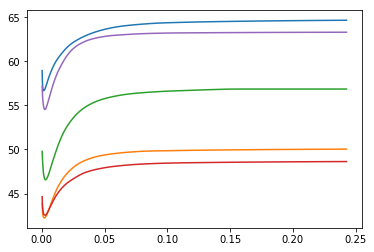

In [312]:
plot(regr.alphas_, regr.mse_path_)

In [369]:
msd = np.matrix([np.mean(regr.mse_path_, axis=1), np.std(regr.mse_path_, axis=1)]).transpose()

TypeError: data type not understood

In [368]:
test = np.matrix([np.mean(regr.mse_path_, axis=1), np.std(regr.mse_path_, axis=1)]).transpose()
test

matrix([[56.69893957,  6.57906502],
        [56.69030008,  6.57868301],
        [56.68121281,  6.57827797],
        [56.67166706,  6.57784874],
        [56.66165366,  6.57739413],
        [56.65116525,  6.57691292],
        [56.64019659,  6.57640384],
        [56.62685664,  6.57580107],
        [56.60701713,  6.57496797],
        [56.58627889,  6.57409942],
        [56.56463625,  6.57319589],
        [56.54264468,  6.57198434],
        [56.52103698,  6.57091987],
        [56.49556496,  6.56997526],
        [56.4648302 ,  6.56597029],
        [56.42819018,  6.56156949],
        [56.38414714,  6.55617992],
        [56.33417918,  6.55342395],
        [56.27510095,  6.55267143],
        [56.21110398,  6.55163435],
        [56.13805425,  6.54965236],
        [56.05963059,  6.54697091],
        [55.97114819,  6.54164302],
        [55.8710166 ,  6.53518021],
        [55.76103168,  6.52791461],
        [55.64308182,  6.51952634],
        [55.51242487,  6.51589571],
        [55.36960661,  6.510